#  Import Required Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2


# Data Preprocessing

In [2]:
# Parameters
image_size = (256, 256)
diseased_dir = "dataset/train/diseased"
healthy_dir = "dataset/train/healthy"

# Custom function to load images
def load_images_from_folder(folder, label, image_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if filename.endswith('.jpg') or filename.endswith('.png'):
            try:
                img = Image.open(file_path).resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load diseased and healthy images
diseased_images, diseased_labels = load_images_from_folder(diseased_dir, 1, image_size)
healthy_images, healthy_labels = load_images_from_folder(healthy_dir, 0, image_size)

# Combine and shuffle dataset
all_images = np.array(diseased_images + healthy_images)
all_labels = np.array(diseased_labels + healthy_labels)

# Shuffle the dataset
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)


Training set size: (1367, 256, 256, 3)
Validation set size: (342, 256, 256, 3)


# Visualize Class Distribution

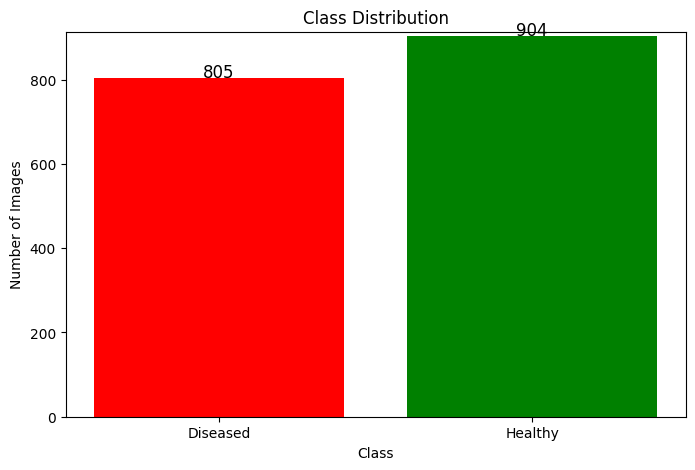

In [3]:
# Count images in each class
diseased_count = len(diseased_images)
healthy_count = len(healthy_images)

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(["Diseased", "Healthy"], [diseased_count, healthy_count], color=['red', 'green'])

# Add text above bars
counts = [diseased_count, healthy_count]
for bar, count in zip(bars, counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 1,              
        str(count),                        
        ha='center',                       
        fontsize=12                        
    )

# Add chart details
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.ylim(0, max(counts) + 10)  
plt.show()



# Visualize Sample Images

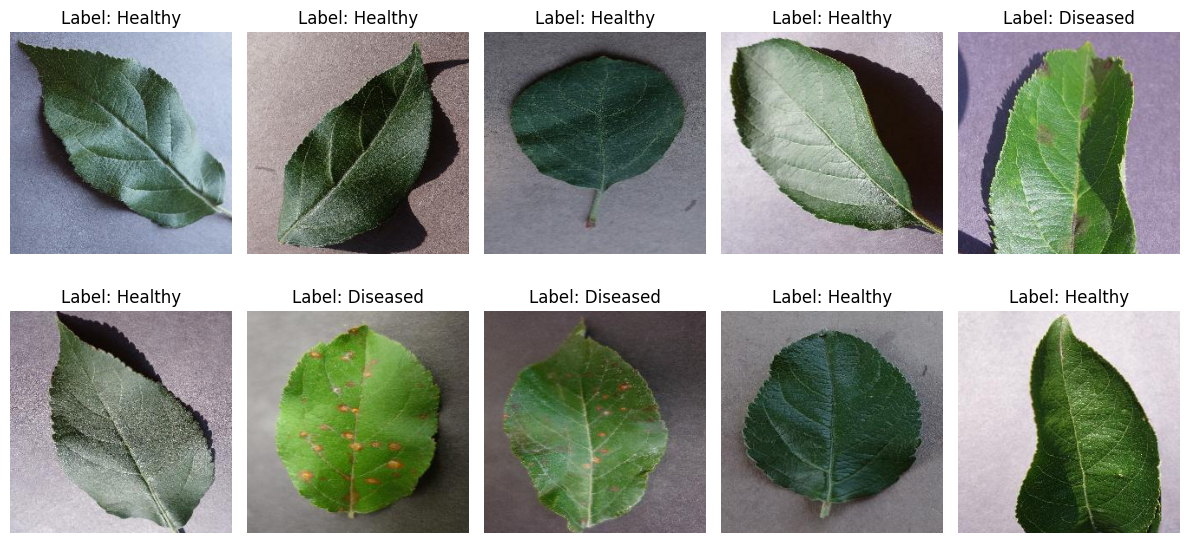

In [4]:
# Visualize some training images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_train[i])
    axes[i].set_title("Label: " + ("Diseased" if y_train[i] == 1 else "Healthy"))
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Apply Data Augmentation

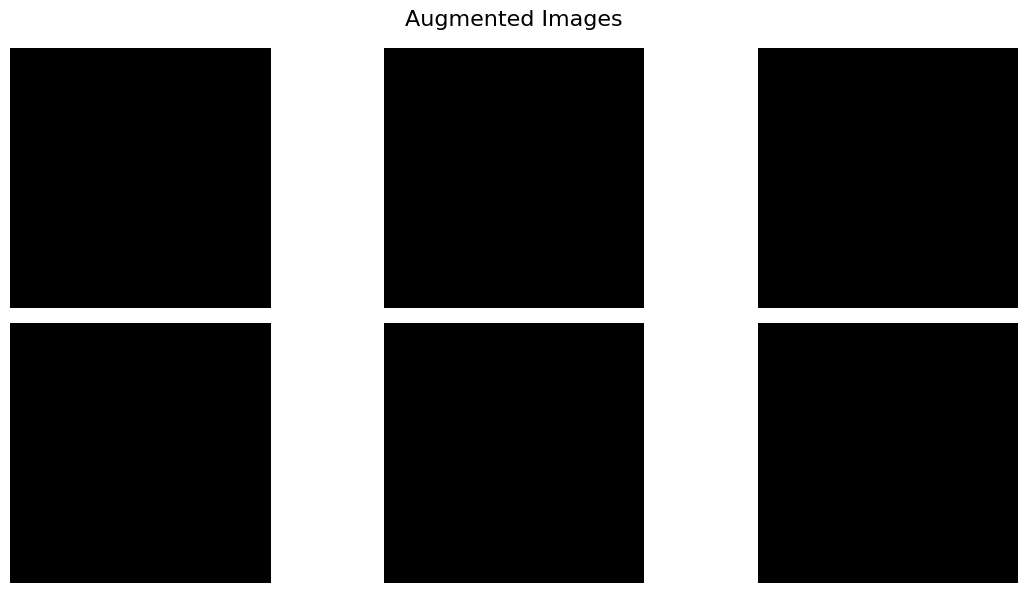

In [5]:
# Define the data augmentation pipeline
augmentor = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize Augmented Images
sample_image = X_train[0]  
sample_image = np.expand_dims(sample_image, axis=0)  
augmented_images = augmentor.flow(sample_image)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    augmented_img = next(augmented_images)[0]
    plt.imshow(augmented_img)
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()


# Apply Histogram Equalization

In [6]:
# Function to apply histogram equalization
def histogram_equalization(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    l = cv2.equalizeHist(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

# Apply histogram equalization to the dataset
X_train_eq = np.array([histogram_equalization((img * 255).astype(np.uint8)) for img in X_train]) / 255.0
X_val_eq = np.array([histogram_equalization((img * 255).astype(np.uint8)) for img in X_val]) / 255.0


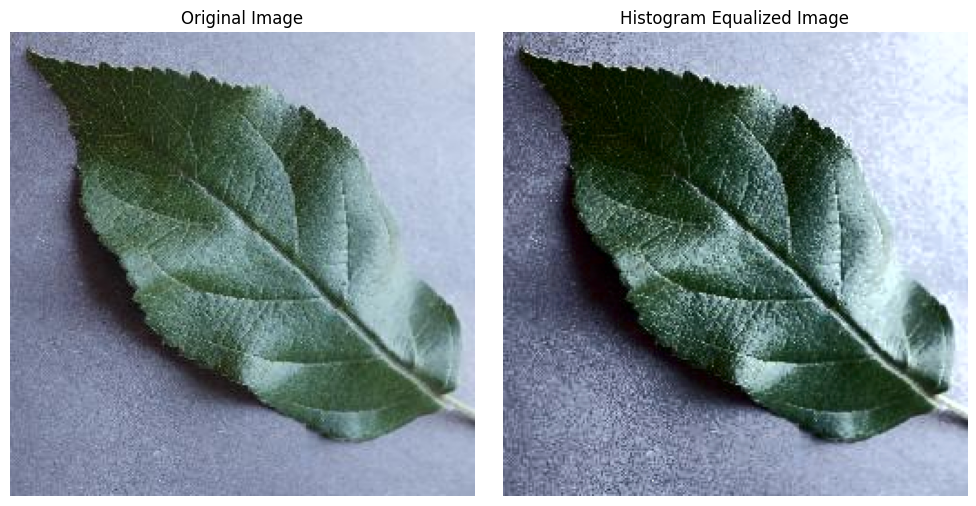

In [7]:
# Select a sample image
original_img = X_train[0]
equalized_img = histogram_equalization((original_img * 255).astype(np.uint8))

# Plot original vs histogram equalized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(equalized_img)
plt.title("Histogram Equalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

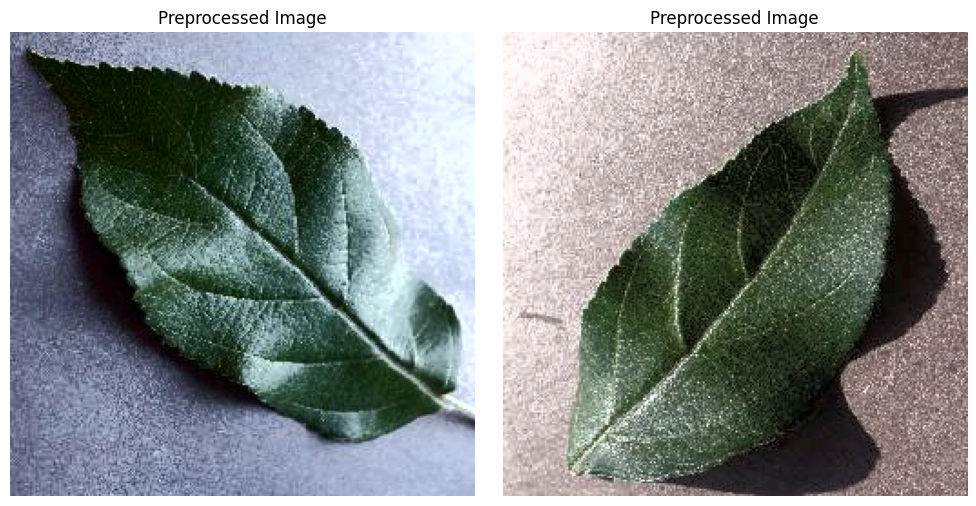

In [8]:
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train_eq[i])
    plt.title("Preprocessed Image")
    plt.axis('off')
plt.tight_layout()
plt.show()


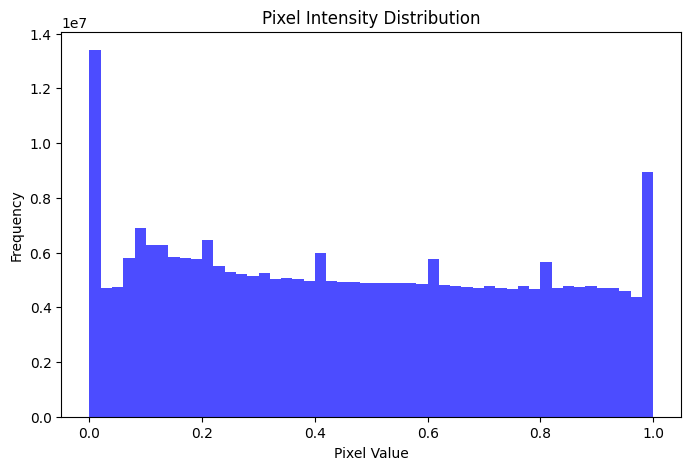

In [9]:
# Flatten pixel values for all training images
all_pixels = X_train_eq.flatten()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Model Creation: Custom CNN

In [10]:
# Define the custom CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

c:\Users\gagan\Downloads\Plant-Disease-Detection-master\gag\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Custom CNN Model

In [11]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
cnn_history = cnn_model.fit(
    X_train_eq, y_train,
    validation_data=(X_val_eq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 827ms/step - accuracy: 0.5300 - loss: 0.8585 - val_accuracy: 0.6023 - val_loss: 1.4352
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 785ms/step - accuracy: 0.7807 - loss: 0.5867 - val_accuracy: 0.8538 - val_loss: 0.3163
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 825ms/step - accuracy: 0.9159 - loss: 0.2494 - val_accuracy: 0.9181 - val_loss: 0.2319
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 809ms/step - accuracy: 0.9441 - loss: 0.1621 - val_accuracy: 0.9211 - val_loss: 0.2277
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 809ms/step - accuracy: 0.9535 - loss: 0.1342 - val_accuracy: 0.9298 - val_loss: 0.1819
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 812ms/step - accuracy: 0.9559 - loss: 0.1340 - val_accuracy: 0.9444 - val_loss: 0.1653
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 810ms/step - accuracy: 0.9730 - loss: 0.0779 - val_accuracy: 0.9386 - val_loss: 0.2098
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - accuracy: 0.9824 - loss: 0.0634 - val_accu

# Visualize Training Progress

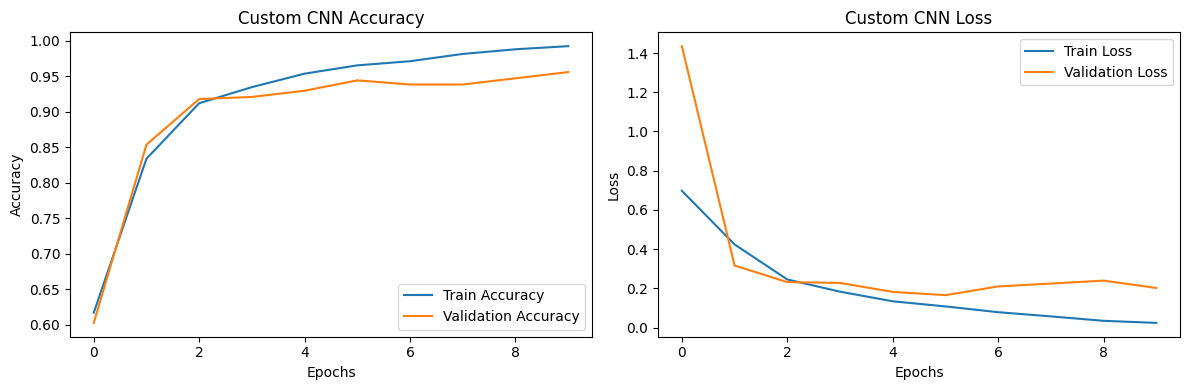

In [12]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Model Creation: MobileNetV2

In [13]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

# Add custom layers
mobilenet_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
mobilenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


C:\Users\gagan\AppData\Local\Temp\ipykernel_11140\1105092639.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,744,001 (48.61 MB)

 Trainable params: 10,486,017 (40.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the MobileNetV2 Model

In [14]:
# Train the MobileNetV2 model
mobilenet_history = mobilenet_model.fit(
    X_train_eq, y_train,
    validation_data=(X_val_eq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.7850 - loss: 3.3278 - val_accuracy: 0.9737 - val_loss: 0.1766
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 436ms/step - accuracy: 0.9837 - loss: 0.1569 - val_accuracy: 0.9854 - val_loss: 0.0548
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 464ms/step - accuracy: 0.9861 - loss: 0.0445 - val_accuracy: 0.9795 - val_loss: 0.0577
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9872 - loss: 0.0329 - val_accuracy: 0.9912 - val_loss: 0.0364
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 814ms/step - accuracy: 0.9939 - loss: 0.0142 - val_accuracy: 0.9942 - val_loss: 0.0429
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 941ms/step - accuracy: 0.9973 - loss: 0.0103 - val_accuracy: 0.9854 - val_loss: 0.0562
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9967 - loss: 0.0065 - val_accuracy: 0.9795 - val_loss: 0.0783
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9979 - loss: 0.0169 - val_accuracy: 

#  Visualize Training Progress

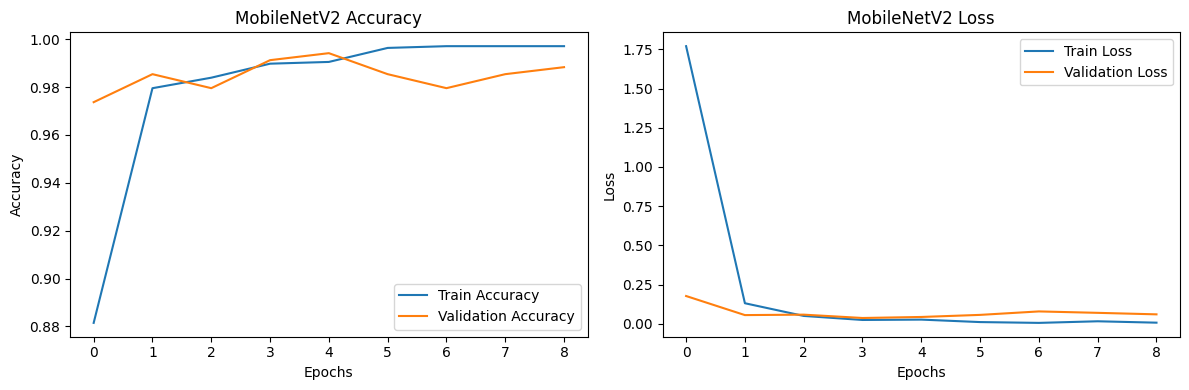

In [15]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], label='Train Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate and Compare with Other Models

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.9910 - loss: 0.0312
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9588 - loss: 0.1194
Custom CNN - Accuracy: 94.44%, Loss: 0.1653
MobileNetV2 - Accuracy: 99.12%, Loss: 0.0364


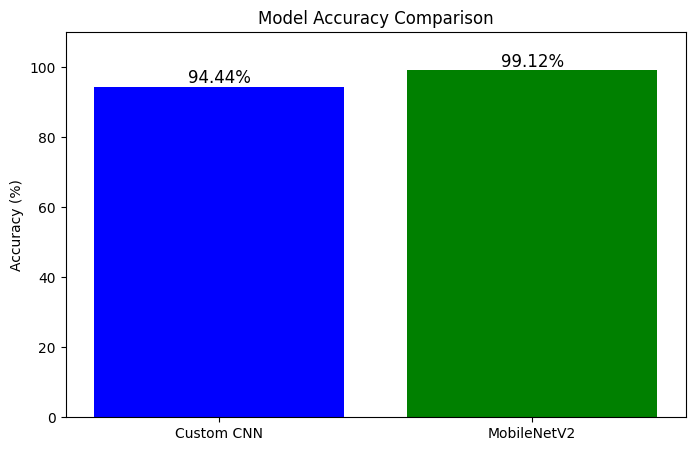

In [16]:
# Evaluate both models
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(X_val_eq, y_val)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val_eq, y_val)

# Print results
print(f"Custom CNN - Accuracy: {cnn_accuracy*100:.2f}%, Loss: {cnn_loss:.4f}")
print(f"MobileNetV2 - Accuracy: {mobilenet_accuracy*100:.2f}%, Loss: {mobilenet_loss:.4f}")

# Compare accuracies
models = ["Custom CNN", "MobileNetV2"]
accuracies = [cnn_accuracy * 100, mobilenet_accuracy * 100]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'green'])

# Add text above bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        bar.get_height() + 1,              
        f"{acc:.2f}%",                     
        ha='center',                       
        fontsize=12                       
    )

# Add chart details
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 110)  
plt.show()
